In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [107]:
#assigning datasets
train = pd.read_csv('/kaggle/input/airplane-accidents-severity-dataset/train.csv')
test = pd.read_csv('/kaggle/input/airplane-accidents-severity-dataset/test.csv')
sample = pd.read_csv('/kaggle/input/airplane-accidents-severity-dataset/sample_submission.csv')

In [108]:
test.describe()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,41.825224,12.946400,6.574800,65.368058,0.376197,79.993068,3.853600,32383.134179,1.990800,0.250886,6186.283200
std,16.280187,3.523364,7.179542,11.442005,0.116960,2.713833,1.877652,9485.096436,1.018592,0.387663,3602.235035
min,0.000000,1.000000,0.000000,20.966272,0.143376,74.740000,1.0000000,831.695553,0.000000,0.000368,1.000000
25%,30.593607,11.000000,1.000000,57.702826,0.292583,77.930000,2.000000,26008.851717,1.000000,0.013136,3071.750000
50%,41.461187,13.000000,4.000000,66.066545,0.357404,79.600000,4.000000,32472.865497,2.000000,0.072466,6159.500000
75%,52.751142,15.000000,9.000000,73.119872,0.441699,81.530000,5.000000,38759.519071,3.000000,0.315407,9309.250000
max,100.000000,23.000000,54.000000,97.994531,0.881926,94.200000,7.000000,62315.408444,5.000000,2.365378,12493.000000


## Highlights of the dataset

<pre>
Accident_ID:              	unique id assigned to each row
Accident_Type_Code:     	  the type of accident (factor, not numeric)
Cabin_Temperature:      	  the last recorded temperature before the incident, measured in degrees fahrenheit
Turbulence_In_gforces:	    the recorded/estimated turbulence experienced during the accident
Control_Metric:               an estimation of how much control the pilot had during the incident given the factors at play
Total_Safety_Complaints: 	 number of complaints from mechanics prior to the accident
Days_Since_Inspection:  	  how long the plane went without inspection before the incident
Safety_Score:           	  a measure of how safe the plane was deemed to be
Severity:	                 a description (4 level factor) on the severity of the crash [Target]
</pre>

In [ ]:
train

In [ ]:
test

In [ ]:
sample.head()

In [ ]:
print(f'test: {test.shape} |  train: {train.shape}')

In [ ]:
#handling missing values
test.isna().sum()


In [ ]:
test.isna().sum()

In [ ]:
# Exploratory-data Analysis
X_train = train.drop(['Accident_ID','Severity'], axis=1)
Y_train = train['Severity']

In [ ]:
Y_train.unique()

In [77]:
#defining int values to catoagorical values 
y = Y_train.unique()
cls = dict()
for i in range(0, len(y)):
    cls[i] = y[i]
inv_cls = {v: int(k) for k, v in cls.items()}
inv_cls
print(cls,'\n', inv_cls)
Y_train = Y_train.map(inv_cls).astype(np.int8)

{0: 0, 1: 1, 2: 2, 3: 3} 
 {0: 0, 1: 1, 2: 2, 3: 3}


In [ ]:
Y_train

1. ### 1. Distribution of Target Variable 

In [ ]:
np.vectorize(cls.get)(pd.unique(Y_train))

In [ ]:
# 1. Distribution of Target Variable
plt.figure(figsize=(13,8))
ax = sns.barplot(Y_train.unique(), Y_train.value_counts().sort_index())
ax.set(xlabel='Accident Severity', ylabel='no of records', title='Accident Severity vs. no. of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

### 2. Distribution of safety score

In [ ]:
pm = list(X_train.columns)
for i in range(0, len(pm)):
    plt.figure(figsize=(13,8))
    sns.distplot(X_train[pm[i]], kde=False)
    plt.show()

# checking correlation 

In [ ]:
g = sns.heatmap(train[pm].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [ ]:
pm

In [ ]:
train['Accident_Type_Code']

In [ ]:
for i in range(0, len(pm)):
    train.boxplot(by ='Accident_Type_Code', column =[pm[i]], grid = False)

In this below section we can observe skewness to following features, Total_Safety_Complaints, Cabin_Temperature, Adverse_Weather_Metric

In [ ]:
for i in range(0, len(pm)):
    g = sns.FacetGrid(train, col='Severity')
    g = g.map(sns.distplot, pm[i])

As we can see, Severity-wise distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.
In this case, it is better to transform it with the log function to reduce this skew.

In [ ]:
X_train['Total_Safety_Complaints'] = np.power(1.2, X_train['Total_Safety_Complaints'])
X_train['Days_Since_Inspection'] = np.power(1.2, X_train['Days_Since_Inspection'])
X_train['Safety_Score'] = np.power(1.2, X_train['Safety_Score'])

In [ ]:
categoricals = ['Accident_Type_Code']

In [ ]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class': 4,
            'metric': {'multi_logloss'},
            'subsample': 0.4,
            'subsample_freq': 1,
            'learning_rate': 0.2,
            'num_iterations': 2000,
            'num_leaves': 100,
            'feature_fraction': 0.8,
            'lambda_l1': 1,
            'lambda_l2': 1
            }

folds = 10
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=seed)

# Score: 84.69896
models = []
for train_index, val_index in kf.split(X_train, Y_train):
    train_X = X_train.iloc[train_index]
    val_X = X_train.iloc[val_index]
    train_y = Y_train.iloc[train_index]
    val_y = Y_train.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100)
    models.append(gbm)

In [ ]:
test['Total_Safety_Complaints'] = np.power(1.2, test['Total_Safety_Complaints'])
test['Days_Since_Inspection'] = np.power(1.2, test['Days_Since_Inspection'])
test['Safety_Score'] = np.power(1.2, test['Safety_Score'])

# ensemble models

In [ ]:
X_train.describe()

In [ ]:
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [ ]:
cv_results  = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

In [ ]:
cv_results

In [ ]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [60]:
X_train.shape
test.columns

Index(['Safety_Score', 'Days_Since_Inspection', 'Total_Safety_Complaints',
       'Control_Metric', 'Turbulence_In_gforces', 'Cabin_Temperature',
       'Accident_Type_Code', 'Max_Elevation', 'Violations',
       'Adverse_Weather_Metric', 'Accident_ID'],
      dtype='object')

# learning curves


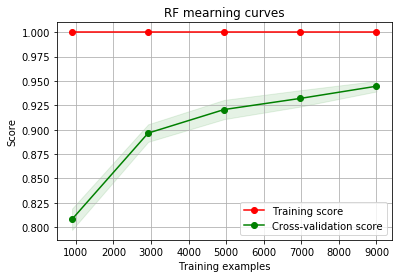

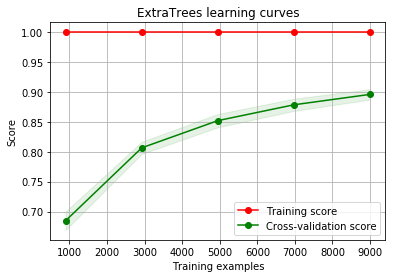

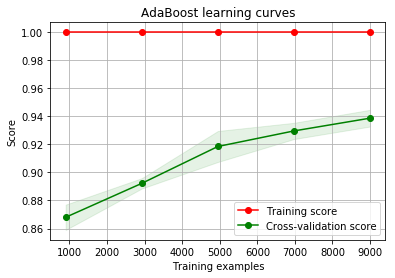

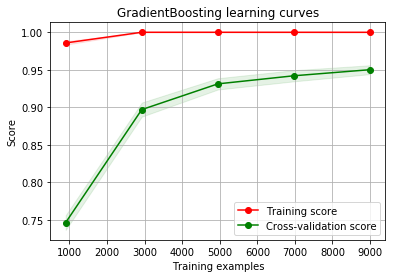

In [75]:
#Deciion, extratree, rfc, grad boosting

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)



# Feature importance

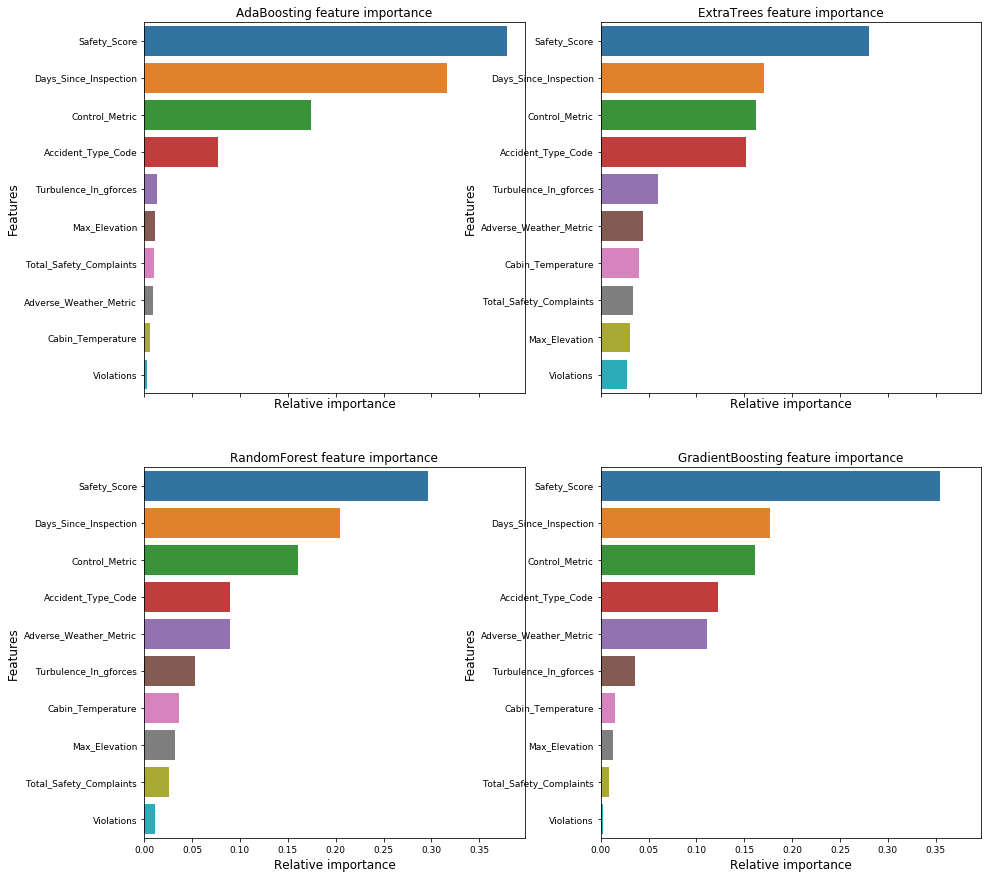

In [50]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [62]:
b = test.drop(columns=['Violations'])

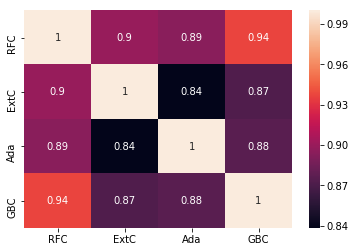

In [63]:
test_Survived_RFC = pd.Series(RFC_best.predict(b), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(b), name="ExtC")
test_Survived_AdaC = pd.Series(ada_best.predict(b), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(b), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [64]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
 ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)


In [68]:
b

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Adverse_Weather_Metric,Accident_ID
0,34.982716,18.488426,2.985984,72.151322,0.388959,78.32,4,37949.724386,0.069692,1
1,40387.919541,15.407022,1.728000,64.585232,0.250841,78.60,7,30194.805567,0.002777,10
2,432.274171,15.407022,1.728000,64.721969,0.336669,86.96,6,17572.925484,0.004316,14
3,1.821050,46.005120,2.488320,66.362808,0.421775,80.86,3,40209.186341,0.199990,17
4,7.252847,26.623333,1.440000,56.107566,0.313228,79.22,2,35495.525408,0.483696,21
...,...,...,...,...,...,...,...,...,...,...
2495,247998.104176,4.299817,7.430084,49.680948,0.470819,77.80,2,48251.586622,0.659387,12484
2496,21994.495034,5.159780,5.159780,71.194166,0.417087,79.77,6,20761.984416,0.005010,12487
2497,807.101096,12.839185,6.191736,91.203282,0.313950,83.96,6,36676.100601,0.008629,12488
2498,1164.162339,10.699321,12.839185,73.154057,0.275003,77.38,6,24211.359510,0.006247,12491


In [ ]:
p = train.Severity.unique()
clss = dict()
for i in range(0, len(p)):
    clss[i] = p[i]
inv_clss = {v: int(k) for k, v in clss.items()}
inv_clss
print(clss,'\n', inv_clss)


In [118]:
Predicted_Severity = pd.Series(votingC.predict(b), name="Severity")
Predicted_Severity = Predicted_Severity.map(clss)
results = pd.concat([test,Predicted_Severity],axis=1)
results=results[['Accident_ID','Severity']]
results.to_csv("ensemble.csv",index=False)

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Highly_Fatal_And_Damaging
4,21,Significant_Damage_And_Fatalities
...,...,...
2495,12484,Highly_Fatal_And_Damaging
2496,12487,Significant_Damage_And_Serious_Injuries
2497,12488,Significant_Damage_And_Serious_Injuries
2498,12491,Significant_Damage_And_Serious_Injuries


In [110]:
results

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID,Predicted_Severity
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1,Highly_Fatal_And_Damaging
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10,Significant_Damage_And_Fatalities
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14,Significant_Damage_And_Serious_Injuries
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17,Highly_Fatal_And_Damaging
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21,Significant_Damage_And_Fatalities
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,68.127854,8,11,49.680948,0.470819,77.80,2,48251.586622,2,0.659387,12484,Highly_Fatal_And_Damaging
2496,54.840183,9,9,71.194166,0.417087,79.77,6,20761.984416,1,0.005010,12487,Significant_Damage_And_Serious_Injuries
2497,36.712329,14,10,91.203282,0.313950,83.96,6,36676.100601,2,0.008629,12488,Significant_Damage_And_Serious_Injuries
2498,38.721461,13,14,73.154057,0.275003,77.38,6,24211.359510,1,0.006247,12491,Significant_Damage_And_Serious_Injuries
